
# Step 1: Understand the Dataset

## 1. Load the Dataset
We load the sentiment analysis dataset using pandas. The dataset contains two important columns: **Text** and **Sentiment**. Each row represents a sentence and its corresponding sentiment label.


In [85]:
import pandas as pd
df = pd.read_csv("sentimentdataset.csv")

In [86]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [87]:
df.head(5)

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [88]:
print("Unique sentiment values before categorization:", df["Sentiment"].unique())

Unique sentiment values before categorization: [' Positive  ' ' Negative  ' ' Neutral   ' ' Anger        '
 ' Fear         ' ' Sadness      ' ' Disgust      ' ' Happiness    '
 ' Joy          ' ' Love         ' ' Amusement    ' ' Enjoyment    '
 ' Admiration   ' ' Affection    ' ' Awe          ' ' Disappointed '
 ' Surprise     ' ' Acceptance   ' ' Adoration    ' ' Anticipation '
 ' Bitter       ' ' Calmness     ' ' Confusion    ' ' Excitement   '
 ' Kind         ' ' Pride        ' ' Shame        ' ' Confusion '
 ' Excitement ' ' Shame ' ' Elation       ' ' Euphoria      '
 ' Contentment   ' ' Serenity      ' ' Gratitude     ' ' Hope          '
 ' Empowerment   ' ' Compassion    ' ' Tenderness    ' ' Arousal       '
 ' Enthusiasm    ' ' Fulfillment  ' ' Reverence     ' ' Compassion'
 ' Fulfillment   ' ' Reverence ' ' Elation   ' ' Despair         '
 ' Grief           ' ' Loneliness      ' ' Jealousy        '
 ' Resentment      ' ' Frustration     ' ' Boredom         '
 ' Anxiety       

In [89]:
df = df[["Text", "Sentiment"]].dropna()
df["Sentiment"] = df["Sentiment"].str.strip()


# Step 2: Preprocessing

## 1. Text Cleaning and Normalization
We preprocess the text data by converting it to lowercase, removing punctuation and stopwords, and applying stemming and lemmatization.


In [90]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Text Preprocessing Function
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words if word not in stop_words]
    return ' '.join(words).strip()

# Apply preprocessing
df["ProcessedText"] = df["Text"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



## 2. Sentiment Categorization with spaCy Embeddings
We use spaCy's pre-trained word embeddings to map raw sentiment labels into one of three standardized sentiment categories: **Positive**, **Negative**, and **Neutral**.


In [91]:

import spacy
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load spaCy model
nlp = spacy.load("en_core_web_md")

# Reference words for sentiment categories
ref_words = {
    "Positive": ["happy", "great", "good", "excellent", "amazing", "positive"],
    "Negative": ["sad", "bad", "terrible", "horrible", "negative", "awful"],
    "Neutral": ["okay", "neutral", "average", "moderate", "indifferent"]
}

# Compute average vector for each category
def compute_average_vector(words):
    vectors = [nlp(word).vector for word in words if nlp(word).has_vector]
    return np.mean(vectors, axis=0) if vectors else np.zeros((nlp("positive").vector.shape[0],))

ref_vectors = {category: compute_average_vector(words) for category, words in ref_words.items()}

# Normalize reference vectors
for category in ref_vectors:
    ref_vectors[category] /= np.linalg.norm(ref_vectors[category])

# Assign sentiment based on cosine similarity
def assign_sentiment_category(sentiment):
    doc = nlp(sentiment)
    if not doc.has_vector:
        return "Neutral"
    word_vector = doc.vector / np.linalg.norm(doc.vector)
    similarities = {category: cosine_similarity([word_vector], [ref_vec])[0][0] for category, ref_vec in ref_vectors.items()}
    return max(similarities, key=similarities.get)

# Apply sentiment classification
df["Sentiment"] = df["Sentiment"].apply(assign_sentiment_category)
print("Unique sentiment values after categorization:", df["Sentiment"].unique())


Unique sentiment values after categorization: ['Neutral' 'Positive' 'Negative']



# Step 3: Define Neural Network Architecture

## Label Encoding and Vectorization
We encode sentiment labels and convert the processed text into TF-IDF features.


In [92]:

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Encode labels
label_encoder = LabelEncoder()
df["SentimentEncoded"] = label_encoder.fit_transform(df["Sentiment"])

# Split dataset
X = df["ProcessedText"]
y = df["SentimentEncoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=30000, min_df=3, stop_words="english", sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



## Choice of Architecture
We use **MLPClassifier** with two hidden layers (100 neurons each) and ReLU activation. The choice of this architecture balances complexity and generalization, with dropout for regularization in DNN. Loss function is **categorical cross-entropy**, suitable for multi-class classification.



# Step 4: Train and Validate the Model

## Handle Class Imbalance with SMOTE
We apply SMOTE (Synthetic Minority Oversampling Technique) to balance classes in training data.


In [93]:

from imblearn.over_sampling import SMOTE

# Apply SMOTE
from collections import Counter
min_class_size = Counter(y_train).most_common()[-1][1]
k_neighbors = min(5, min_class_size - 1) if min_class_size > 1 else 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)



## Train MLP Classifier
We use the Adam optimizer with a constant learning rate. The model is trained for 500 iterations. We experimented using Grid Search CV to find the best parameters for the MLP classifier. We also tried training the MLP without categorizing all the sentiments into 'Positive', 'Negative' and 'Neutral'. With 191 unique sentiment labels, the dataset is highly fragmented, making it difficult for models to learn meaningful patterns. Reducing it to three broad categories ensures better generalization and reduces overfitting.


In [94]:

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# # Define parameter grid for MLP (Added more layers & optimizers)
# param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  # More architectures
#     'activation': ['relu', 'tanh'],  # Activation functions
#     'solver': ['adam', 'sgd'],  # Added SGD optimizer
#     'alpha': [0.0001, 0.001],  # L2 regularization
#     'learning_rate': ['constant', 'adaptive'],  # Learning rate strategy
#     'batch_size': [32],  # Mini-batch training
#     'max_iter': [500]  # Increased training iterations
# }

# # Perform Grid Search with Cross Validation
# mlp = MLPClassifier(random_state=42)
# grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
# grid_search.fit(X_train_tfidf, y_train)

# # Best model
# best_mlp = grid_search.best_estimator_
# print("Best Parameters:", grid_search.best_params_)

# Train MLP Classifier
best_mlp = MLPClassifier(activation='relu', alpha=0.001, batch_size=32,
                         hidden_layer_sizes=(100, 100), learning_rate='constant',
                         max_iter=500, solver='adam', random_state=42)
best_mlp.fit(X_train_tfidf, y_train)

# Predict and evaluate
y_pred = best_mlp.predict(X_test_tfidf)
print(f"MLP Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("MLP Classification Report:\n", classification_report(y_test, y_pred))


MLP Accuracy: 0.6599
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.65      0.67        43
           1       0.67      0.67      0.67        60
           2       0.62      0.66      0.64        44

    accuracy                           0.66       147
   macro avg       0.66      0.66      0.66       147
weighted avg       0.66      0.66      0.66       147



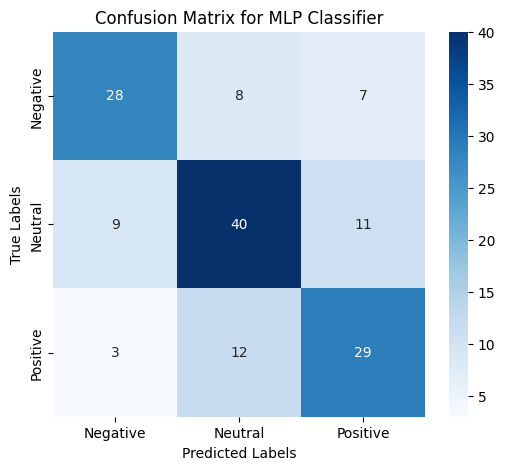

In [95]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()


# Step 5: Evaluate the Model

## Train Deep Neural Network (DNN)
We train a DNN with multiple dense layers and dropout. The model is compiled using the Adam optimizer and evaluated with accuracy and classification report.


In [96]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report


SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Prepare labels
y_train_dnn = to_categorical(y_train, num_classes=3)
y_test_dnn = to_categorical(y_test, num_classes=3)

# Build DNN
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train DNN
model.fit(X_train_tfidf.toarray(), y_train_dnn, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate DNN
y_pred_dnn = np.argmax(model.predict(X_test_tfidf.toarray()), axis=1)
print("DNN Accuracy:", accuracy_score(y_test, y_pred_dnn))
print("DNN Classification Report:\n", classification_report(y_test, y_pred_dnn))


Epoch 1/10


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3624 - loss: 1.0934 - val_accuracy: 0.0000e+00 - val_loss: 1.2492
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4690 - loss: 1.0514 - val_accuracy: 0.1944 - val_loss: 1.1499
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6874 - loss: 0.8501 - val_accuracy: 0.9722 - val_loss: 0.4987
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8820 - loss: 0.3865 - val_accuracy: 1.0000 - val_loss: 0.1462
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9602 - loss: 0.1294 - val_accuracy: 1.0000 - val_loss: 0.0440
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9806 - loss: 0.0619 - val_accuracy: 1.0000 - val_loss: 0.0254
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9699 - loss: 0.0711 - val_accuracy: 0.9722 - val_loss: 0.0558
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9795 - loss: 0.0887 - val_accuracy: 0.8750 - val_loss